In [99]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [100]:
import numpy as np
import pandas as pd

In [101]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [102]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [103]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [104]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [105]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [106]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [107]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Checking out the columns

#### Measurement table

In [108]:
Measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

#### Station table

In [109]:
Station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

# Exploratory Climate Analysis

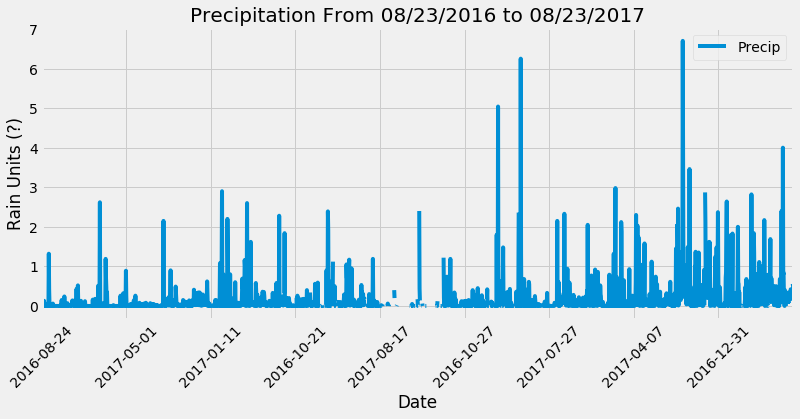

In [110]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# run a query to get the top 1 row of the data sorted by date desc.  (this gest the last date)
results = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1)

# get the last data point, convert to datetime for later
result = results[0]
last_date = dt.datetime.strptime(result[0],'%Y-%m-%d')

# get 1 year prior to last date
last_year = last_date - dt.timedelta(days=365)

# print(last_year)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','prcp'])
# df.set_index('date',inplace=True,)
# df.head()

# Sort the dataframe by date
df.sort_values(by='date')

# df.head()

# Use Pandas Plotting with Matplotlib to plot the data
prcp_chart = df.plot(x='date',y='prcp', rot=45, figsize=(12,5))
# title, formatting the datetimes
prcp_chart.set_title(f'Precipitation From {last_year.strftime("%m/%d/%Y")} to {last_date.strftime("%m/%d/%Y")}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
prcp_chart.legend(['Precip'],loc='best')
plt.xlabel('Date')
plt.ylabel('Rain Units (?)')

# save chart
prcp_chart.get_figure().savefig('images/precipitation.png', pad_inches=1)



# Use Pandas to calcualte the summary statistics for the precipitation data

In [111]:
desc = df.describe()

desc.head()

# desc.savfig('images/describe.png')

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000


In [112]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f'There are {station_count} stations available')

There are 9 stations available


In [113]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [143]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# get the most active station
first_row = active_stations[0]
most_active_station = first_row[0]

station_stats = session.query(Measurement.station, func.max(Measurement.tobs).label('Highest Temp'), func.avg(Measurement.tobs).label('Average Temp')).\
    filter(Measurement.station == most_active_station).group_by(Measurement.station).limit(1)

active_df = pd.DataFrame(station_stats, columns=['station','Highest Temp Recorded', 'Average Temp'])

active_df.head()


,station,Highest Temp Recorded,Average Temp
0,USC00519281,85.0,71.663781


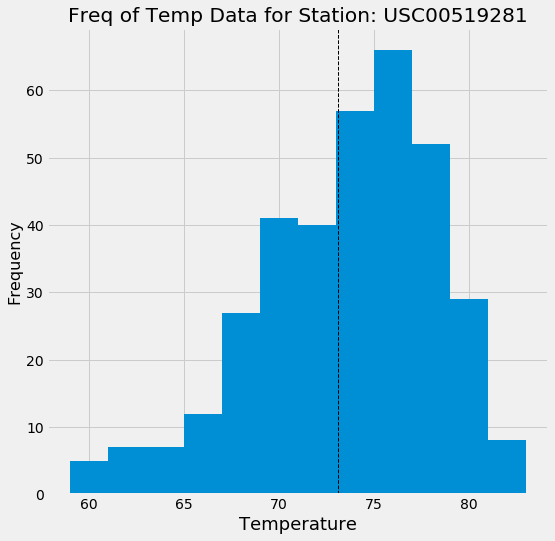

In [201]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.station, func.count(Measurement.tobs).label('Tobs Count')).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())

# just curious...
# all_df = pd.DataFrame(temp_results, columns=['station','Tobs Count'])
# all_df.head(10)

# grab the top row
row = temp_results[0]
most_temps = row[0]

# print(most_temps)

results = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == most_temps, Measurement.date >= last_year)
temp_df = pd.DataFrame(results, columns=['station','tobs'])

# temp_df.head()

temp_df.hist(column="tobs", bins=12, grid=True, figsize=(8,8))
plt.title(f'Freq of Temp Data for Station: {most_temps}')
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.hist(temp_df['tobs'], 20, density=True, alpha=0.7, label="tobs")
plt.axvline(temp_df['tobs'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('images\station-histogram.png')




In [164]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs).label('Minimum'), func.avg(Measurement.tobs).label('Average'), func.max(Measurement.tobs).label('Maximum')).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [165]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year = calc_temps(last_year.strftime("%Y-%m-%d"), last_date.strftime("%Y-%m-%d"))
print(prev_year)

[(58.0, 74.59058295964125, 87.0)]


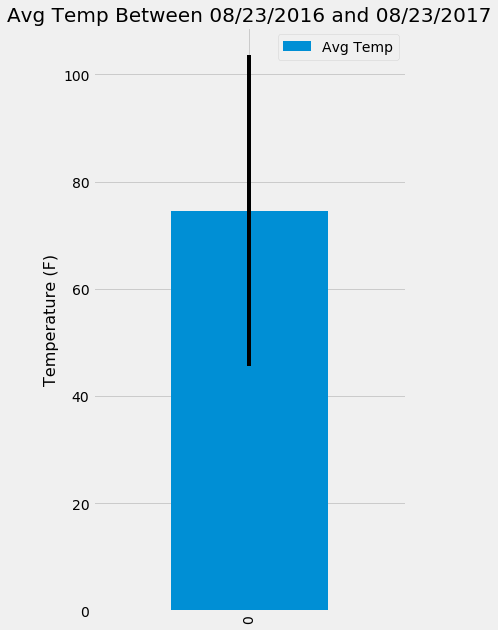

In [198]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

prev_year_df = pd.DataFrame(prev_year, columns=['Minimum','Average','Maximum'])
prev_year_df['yErr'] = prev_year_df['Maximum'] - prev_year_df['Minimum']
# prev_year_df.head()

temp_chart = prev_year_df.plot.bar(y='Average', yerr='yErr', figsize=(5,10))
temp_chart.set_title(f'Avg Temp Between {last_year.strftime("%m/%d/%Y")} and {last_date.strftime("%m/%d/%Y")}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.ylabel('Temperature (F)', fontsize=16)
temp_chart.legend(['Avg Temp'],loc='best')

# save chart
temp_chart.get_figure().savefig('Images/temperature.png')


In [192]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('total prcp')).\
    filter(Measurement.station == Station.station, Measurement.date >= last_year).\
    group_by(Measurement.station, Station.latitude, Station.longitude, Station.elevation).\
    order_by(func.sum(Measurement.prcp).desc())

total_rain_df = pd.DataFrame(results, columns=['station','name','latitude','longitude','elevation', 'total prcp'])
total_rain_df


,station,name,latitude,longitude,elevation,total prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.11
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,68.24
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.36
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,37.99
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.19
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


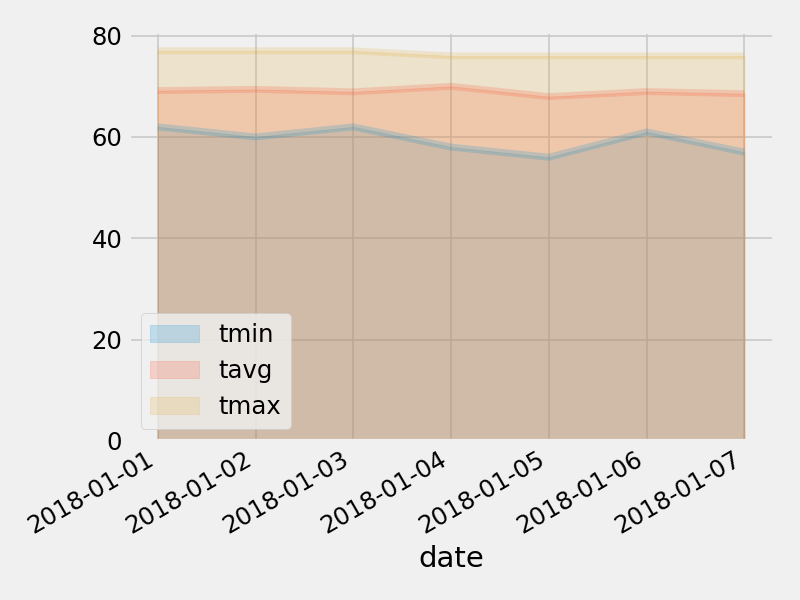

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
